In [3]:
# Library Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Loading/Reading in the Data
import yfinance as yf
data = yf.download('BTC-USD')
#df = pd.read_csv("BTC-USD.csv")

# Data Preprocessing
### Setting the datetime index as the date, only selecting the 'Close' column, then only the last 1000 closing prices.
#df = df.set_index("Date")[['Close']].tail(1000)
#df = df.set_index(pd.to_datetime(df.index))

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
#df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

[*********************100%***********************]  1 of 1 completed


In [4]:
new_df = pd.DataFrame(data['Close']).set_index(pd.to_datetime(pd.DataFrame(data['Close']).index))
new_df = pd.DataFrame(scaler.fit_transform(new_df), columns=new_df.columns, index=new_df.index)

In [5]:
df = new_df[-2000:]
print(df.head())

               Close
Date                
2014-11-11  0.009814
2014-11-12  0.012705
2014-11-13  0.012559
2014-11-14  0.011373
2014-11-15  0.010250


In [6]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)


def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Create a specified number of hidden layers for an RNN
    Optional: Adds regularization option, dropout layer to prevent potential overfitting if necessary
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

In [8]:
### How many periods looking back to train
n_per_in  = 30

# How many periods ahead to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(list(df.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [168]:
model = Sequential()

# Activation
activ = "softsign"

# Input layer
model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=0, n_nodes=12, activation=activ)

# Final Hidden layer
model.add(LSTM(10, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_119 (LSTM)              (None, 30, 30)            3840      
_________________________________________________________________
lstm_120 (LSTM)              (None, 10)                1640      
_________________________________________________________________
dense_16 (Dense)             (None, 10)                110       
Total params: 5,590
Trainable params: 5,590
Non-trainable params: 0
_________________________________________________________________


In [169]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [176]:
res = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2, use_multiprocessing=True)

Train on 1568 samples, validate on 393 samples
Epoch 1/20
1568/1568 [==============================] - 2s 1ms/step - loss: 3.0304e-04 - accuracy: 0.1792 - val_loss: 0.0029 - val_accuracy: 0.2010
Epoch 2/20
1568/1568 [==============================] - 2s 1ms/step - loss: 3.0286e-04 - accuracy: 0.1798 - val_loss: 0.0030 - val_accuracy: 0.1832
Epoch 3/20
1568/1568 [==============================] - 2s 978us/step - loss: 2.9864e-04 - accuracy: 0.1658 - val_loss: 0.0028 - val_accuracy: 0.2265
Epoch 4/20
1568/1568 [==============================] - 2s 1ms/step - loss: 3.0129e-04 - accuracy: 0.1849 - val_loss: 0.0031 - val_accuracy: 0.2087
Epoch 5/20
1568/1568 [==============================] - 2s 1ms/step - loss: 3.0794e-04 - accuracy: 0.1511 - val_loss: 0.0030 - val_accuracy: 0.1934
Epoch 6/20
1568/1568 [==============================] - 2s 1ms/step - loss: 3.0832e-04 - accuracy: 0.1767 - val_loss: 0.0032 - val_accuracy: 0.2290
Epoch 7/20
1568/1568 [==============================] - 2s 1ms/

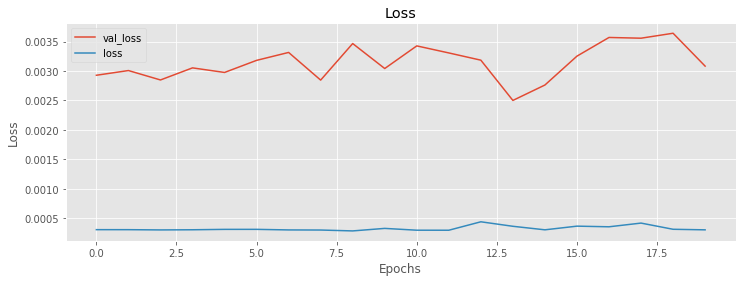

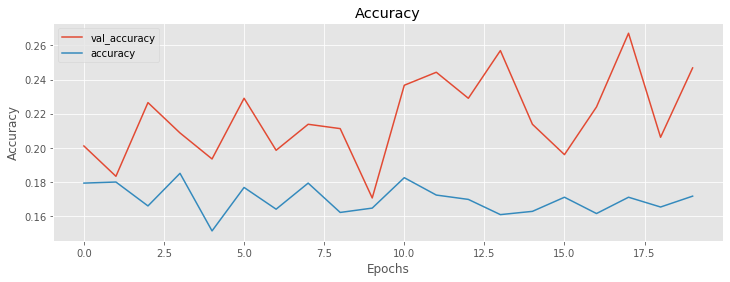

In [177]:
visualize_training_results(res)

Predicted Prices:
 [[6739.766000096815], [6766.101259259967], [6621.27345514065], [6593.265613383074], [6654.548348730857], [6481.150185403102], [6500.202657221376], [6420.814575138909], [6435.342149673335], [6315.385447217129]]

Actual Prices:
 [[6642.10986328125], [7116.80419921875], [7096.1845703125], [7257.6650390625], [7189.4248046875], [6881.95849609375], [6880.3232421875], [7117.20751953125], [7429.724609375], [7582.38134765625]]


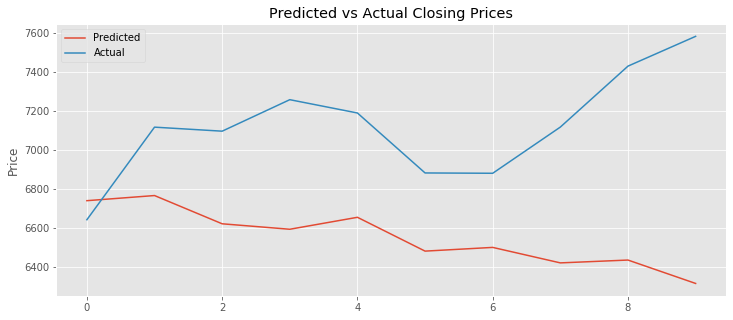

In [178]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
#plt.savefig("BTC_validation.png")
plt.show()

                  Close
2020-04-25  7764.305461
2020-04-26  7872.526449
2020-04-27  7808.971765
2020-04-28  8017.902952
2020-04-29  7847.096284
2020-04-30  8125.579847
2020-05-01  8196.629198
2020-05-02  8453.939765
2020-05-03  8692.218587
2020-05-04  8939.356052


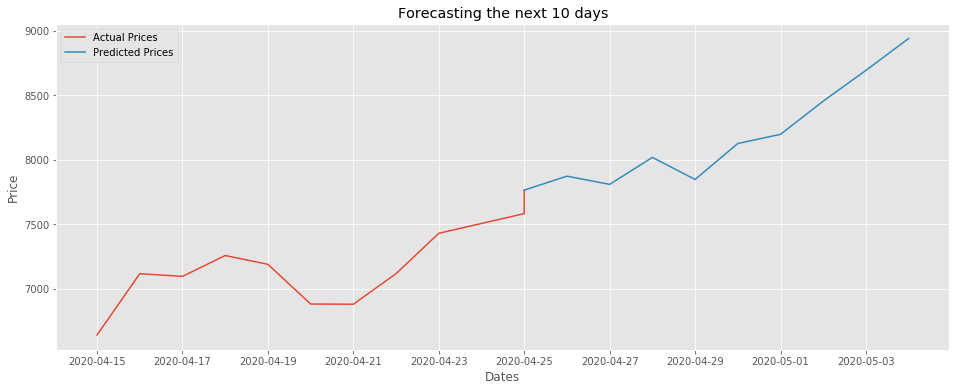

In [179]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["Close"]].tail(pers)), index=df.Close.tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
#plt.savefig("BTC_predictions.png")
plt.show()

In [175]:
help(model.fit)

Help on method fit in module keras.engine.training:

fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False, **kwargs) method of keras.engine.sequential.Sequential instance
    Trains the model for a fixed number of epochs (iterations on a dataset).
    
    # Arguments
        x: Input data. It could be:
            - A Numpy array (or array-like), or a list of arrays
              (in case the model has multiple inputs).
            - A dict mapping input names to the corresponding
              array/tensors, if the model has named inputs.
            - A generator or `keras.utils.Sequence` returning
              `(inputs, targets)` or `(inputs, targets, sample weights)`.
            - None (default) if feeding from framework-native
